## Import necessary packages tutorial

In [1]:
import renom as rm
from renom.utility.initializer import Uniform, GlorotUniform
import gym

/Users/thakur/ReNom/renom/cuda/__init__.py:12: UserWarning: Couldn't find cuda modules. No module named 'renom.cuda.cuda_base'
  warnings.warn("Couldn't find cuda modules. %s" % e)
/Users/thakur/ReNom/renom/cuda/__init__.py:29: UserWarning: Couldn't find cuda modules.
  warnings.warn("Couldn't find cuda modules.")


## Deifne the environment tutorial

In [2]:
env = gym.make('Pendulum-v0')

[2018-03-19 10:44:11,141] Making new env: Pendulum-v0


## Define the actor network tutorial

In [3]:
class Actor(rm.Model):
    
    '''Here considered 3-layer network (excluding input layer). Feel free to change the network depth 
    and check the results. The output-layer number of nuerons are equal to number of actions.
    In the example of OpenAI Gym's Pendlum-v0 environment number of actions are 1.'''
    
    def __init__(self, env, layer_size):
        self._layers = []
        self.env = env
        self._l1 = rm.Dense(layer_size[0], initializer=GlorotUniform())
        self._l2 = rm.Dense(layer_size[1], initializer=GlorotUniform())
        self._l3 = rm.Dense(self.env.action_space.shape[0], initializer=Uniform(min=-0.003, max=0.003))
        self._layers = [self._l1, self._l2, self._l3]
    
    def forward(self, x):
        '''Neural Network inputs are state information, outputs are actions. '''
        h1 = rm.relu(self._l1(x))
        h2 = rm.relu(self._l2(h1))
        h3 = rm.tanh(self._l3(h2)) 
        #h = self._l3(h2)
        h = h3*self.env.action_space.high[0]
        return h
    
    def weigiht_decay(self):
        '''To minimize over fitting considered L2-norm (it is an optional)'''
        weight_decay = 0
        for i in range(len(self._layers)):
            weight_decay += rm.sum(self._layers[i].params.w**2)
        return weight_decay


# Define the Critic network tutorial

In [4]:
class Critic(rm.Model):
    '''Here considered a 3-layer network (input layer, hidden layer-1, hidden layer-2, output layer)
        At input-layer state information, 2nd-hidden layer actions are applied, last layer has a single neuron'''
    def __init__(self, env, layer_size):        
        self._layers = []
        self.env = env
        self._l1 = rm.Dense(layer_size[0], initializer=GlorotUniform())
        self._l2 = rm.Dense(layer_size[1], initializer=GlorotUniform())
        self._l3 = rm.Dense(1, initializer=Uniform(min=-0.003, max=0.003))
        self._layers = [self._l1, self._l2, self._l3]
  
    def forward(self, x, action):
        '''Q(s,a) calculation for a given (state, action) pair'''
        h1 = rm.relu(self._l1(x))
        h2 = rm.relu(self._l2(rm.concat(h1,action))) # actions are applied at 2nd hidden layer
        h = self._l3(h2)        
        return h
    
    def weigiht_decay(self):
        '''To minimize over fitting considered L2-norm (it is an optional)'''
        weight_decay = 0
        for i in range(len(self._layers)):
            weight_decay += rm.sum(self._layers[i].params.w**2)
        return weight_decay

## Instantiating the actor & ciritic networks 

In [5]:
from renom.algorithm.reinforcement.ddpg import DDPG
layer_size = [400, 300] # two-hidden layers dimension
actor_network = Actor(env=env,layer_size=layer_size)
critic_network = Critic(env=env, layer_size=layer_size)
target_actor_network = Actor(env=env,layer_size=layer_size)
target_critic_network = Critic(env=env, layer_size=layer_size)

## Instantiating the DDPG class

In [6]:
ddpg = DDPG(env=env, actor_network=actor_network, critic_network=critic_network, \
            target_actor_network=target_actor_network, target_critic_network=target_critic_network)
# ddpg = DDPG(env=env) # for default

## Training 

In [7]:
[reward_list, loss_list]=ddpg.train(num_episodes=300)

episode: 000 Total reward:-1064.16 avg loss:1.5441: 100%|██████████| 200/200 [00:04<00:00, 40.33it/s]
episode: 001 Total reward:-1537.06 avg loss:0.0647: 100%|██████████| 200/200 [00:06<00:00, 19.95it/s]
episode: 002 Total reward:-1792.93 avg loss:0.0213: 100%|██████████| 200/200 [00:07<00:00, 28.47it/s]
episode: 003 Total reward:-1768.55 avg loss:0.0167: 100%|██████████| 200/200 [00:06<00:00, 30.63it/s]
episode: 004 Total reward:-1628.95 avg loss:0.0195: 100%|██████████| 200/200 [00:06<00:00, 28.45it/s]
episode: 005 Total reward:-1624.17 avg loss:0.0162: 100%|██████████| 200/200 [00:07<00:00, 28.02it/s]
episode: 006 Total reward:-1468.53 avg loss:0.0349: 100%|██████████| 200/200 [00:07<00:00, 26.94it/s]
episode: 007 Total reward:-1650.87 avg loss:0.0416: 100%|██████████| 200/200 [00:07<00:00, 25.74it/s]
episode: 008 Total reward:-1639.69 avg loss:0.0721: 100%|██████████| 200/200 [00:06<00:00, 28.82it/s]
episode: 009 Total reward:-1536.54 avg loss:0.0803: 100%|██████████| 200/200 [00:0

episode: 080 Total reward:-132.31 avg loss:8.9046: 100%|██████████| 200/200 [00:07<00:00, 28.00it/s]
episode: 081 Total reward:-131.17 avg loss:13.5976: 100%|██████████| 200/200 [00:06<00:00, 29.72it/s]
episode: 082 Total reward:-392.03 avg loss:8.7534: 100%|██████████| 200/200 [00:07<00:00, 26.89it/s]
episode: 083 Total reward:-256.11 avg loss:12.4325: 100%|██████████| 200/200 [00:07<00:00, 28.30it/s]
episode: 084 Total reward:-258.17 avg loss:13.4849: 100%|██████████| 200/200 [00:07<00:00, 26.92it/s]
episode: 085 Total reward:-382.32 avg loss:11.8349: 100%|██████████| 200/200 [00:07<00:00, 28.15it/s]
episode: 086 Total reward:-258.50 avg loss:11.9000: 100%|██████████| 200/200 [00:07<00:00, 26.95it/s]
episode: 087 Total reward:-261.44 avg loss:13.0350: 100%|██████████| 200/200 [00:07<00:00, 22.31it/s]
episode: 088 Total reward:-378.99 avg loss:12.5259: 100%|██████████| 200/200 [00:07<00:00, 27.23it/s]
episode: 089 Total reward:-504.80 avg loss:15.5679: 100%|██████████| 200/200 [00:06<

episode: 160 Total reward:-116.26 avg loss:22.9410: 100%|██████████| 200/200 [00:06<00:00, 31.58it/s]
episode: 161 Total reward:-127.02 avg loss:15.9525: 100%|██████████| 200/200 [00:06<00:00, 31.89it/s]
episode: 162 Total reward:-4.51 avg loss:18.1362: 100%|██████████| 200/200 [00:06<00:00, 31.43it/s]
episode: 163 Total reward:-370.37 avg loss:19.8421: 100%|██████████| 200/200 [00:07<00:00, 27.10it/s]
episode: 164 Total reward:-129.38 avg loss:19.4519: 100%|██████████| 200/200 [00:07<00:00, 27.09it/s]
episode: 165 Total reward:-121.62 avg loss:17.6776: 100%|██████████| 200/200 [00:06<00:00, 30.07it/s]
episode: 166 Total reward:-240.67 avg loss:18.8341: 100%|██████████| 200/200 [00:06<00:00, 28.99it/s]
episode: 167 Total reward:-2.67 avg loss:17.1877: 100%|██████████| 200/200 [00:06<00:00, 28.79it/s]
episode: 168 Total reward:-123.81 avg loss:18.4037: 100%|██████████| 200/200 [00:06<00:00, 29.98it/s]
episode: 169 Total reward:-126.34 avg loss:15.4846: 100%|██████████| 200/200 [00:06<00

episode: 240 Total reward:-121.98 avg loss:21.3592: 100%|██████████| 200/200 [00:06<00:00, 29.25it/s]
episode: 241 Total reward:-329.69 avg loss:10.9061: 100%|██████████| 200/200 [00:06<00:00, 29.89it/s]
episode: 242 Total reward:-129.05 avg loss:15.0319: 100%|██████████| 200/200 [00:06<00:00, 28.83it/s]
episode: 243 Total reward:-2.09 avg loss:16.1102: 100%|██████████| 200/200 [00:07<00:00, 27.90it/s]
episode: 244 Total reward:-119.58 avg loss:11.5286: 100%|██████████| 200/200 [00:06<00:00, 29.29it/s]
episode: 245 Total reward:-117.27 avg loss:17.6068: 100%|██████████| 200/200 [00:06<00:00, 29.27it/s]
episode: 246 Total reward:-117.42 avg loss:18.9835: 100%|██████████| 200/200 [00:07<00:00, 27.73it/s]
episode: 247 Total reward:-356.85 avg loss:26.8200: 100%|██████████| 200/200 [00:06<00:00, 29.82it/s]
episode: 248 Total reward:-124.82 avg loss:14.3214: 100%|██████████| 200/200 [00:06<00:00, 30.59it/s]
episode: 249 Total reward:-363.49 avg loss:14.6856: 100%|██████████| 200/200 [00:06<

## Testing

In [8]:
test_reward_list = ddpg.test(render=False,episodes=10)

episode: 009 Total reward:-117.02: 100%|██████████| 200/200 [00:00<00:00, 237.68it/s]    


## Plotting the test result

Text(0,0.5,'Total Rewards per Episode')

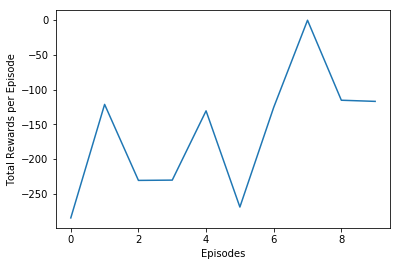

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(test_reward_list)
plt.xlabel("Episodes")
plt.ylabel("Total Rewards per Episode")